In [1]:
import sys
sys.path.insert(0, '..')
from libs.dataloaders import mahnob, deap, dreamer
from libs.utils import finetuning
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

from libs.dataloaders import mahnob, deap, dreamer
from joblib import Parallel, delayed
import xml.etree.ElementTree as ET

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import normalize
from torch.utils.tensorboard import SummaryWriter

import pickle

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ngg7n63s because the default path (/home/dutruong/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def trainmax2test_deap(train, test):
    '''subject pc bootstrap -> subject bootstrap'''
    ## Max with most nPC
    _train = np.nan_to_num(train, nan=-1.) # hacky way to get around all nan argmax
    _train = np.flip(_train, axis=1)
    _argmax = np.argmax(_train, axis=1) # find max acc per pc
    _test = np.flip(test, axis=1)
    return np.array([[k[_argmax[n_subj, n_k]] for n_k, k in enumerate(subj.T)] for n_subj, subj in enumerate(_test)])
def gen_y_deap(aggop_subj, features, session_mask=None):
    y =[]
    for feat in features:       
        y.append(trainmax2test_deap(feat[0], feat[1]))
    y = np.array(y)
    y = np.nanmean(y, axis=-1) # 4 -> Subjects

    if session_mask is not None:
        y = y[:, session_mask]

    means = aggop_subj(y, axis=-1)
    stderrs = np.nanstd(y, axis=-1)/np.sqrt(np.count_nonzero(~np.isnan(y), axis=-1))
    return means, stderrs

In [3]:
def gen_y(aggop_subj, features):
    def trainmax2test(train, test):
        # hacky way to get around all nan argmax
        _train = np.nan_to_num(train[:,0,:], nan=-1.)
        _test = test[:,0,:]
        _argmax = np.argmax(_train, axis=1)
        return [_test[n, _argmax[n]] if i[_argmax[n]] >= 0 else np.nan for n,i in enumerate(_train)]
    
    y =[]
    for feat in features:    
        y.append(trainmax2test(feat[0], feat[1]))
    y = np.array(y)

    means = aggop_subj(y, axis=1) # (4,)
    stderrs = np.nanstd(y, axis=1)/np.sqrt(np.count_nonzero(~np.isnan(y), axis=1)) # (4,)
    return means, stderrs
# y_mean, yerr_mean  = gen_y(np.nanmean)
# y_median, yerr_median  = gen_y(np.nanmedian)
# x = ["AvgFreqPwr", "AvgFreqPwr Topo", "VGG16 Specto", "VGG16 Topo"]


In [ ]:
def f1_score(

# Standard vs DFT
- x axis: [“AvgFreqPwr”, “Topo”, “VGG16(Topo)“, “VGG16(Specto)“]
- 3 grouped bars per x: mahnob, dreamer, deap
- y: acc

In [21]:
path = '/net2/sandbox/deep-eeg/nb-results'

results = ['result_avgfreqpwr', 'result_topo', 'result_vgg16', 'result_specto_vgg16']
datasets = ['mahnob', 'deap', 'dreamer']
data = np.zeros((len(datasets), len(results), 2))
for d, ds in enumerate(datasets):
    print(ds)
    
    for f, feat in enumerate(results):
        data_acc = []
        if ds == 'mahnob':
            result_file = os.path.join(path, f'{feat}.pkl')
        else:
            result_file = os.path.join(path, f'{ds}_{feat}.pkl')
        with open(result_file, 'rb') as fin:
            result = pickle.load(fin)
            data_acc.append((result['train_acc'], result['acc']))
        if ds == 'mahnob':
            y_mean, yerr_mean  = gen_y(np.nanmean, data_acc)
            # print(y_mean)
            y_median, yerr_median  = gen_y(np.nanmedian, data_acc)   
        else:
            y_mean, yerr_mean  = gen_y_deap(np.nanmean, data_acc)
            # print(y_mean)
        data[d,f,0] = y_mean
        data[d,f,1] = yerr_mean
print(data)

mahnob
deap
dreamer
[[[0.54528986 0.02509605]
  [0.56886646 0.02304921]
  [0.53716356 0.02743036]
  [0.55690476 0.03632428]]

 [[0.61228572 0.02654268]
  [0.59697556 0.03860606]
  [0.54888192 0.03426291]
  [0.59543132 0.0381211 ]]

 [[0.58937198 0.02180321]
  [0.56280193 0.02517283]
  [0.56280193 0.03155006]
  [0.50241546 0.02948013]]]


/tmp/ipykernel_1071/1692967976.py:14: RuntimeWarning: Mean of empty slice
  y = np.nanmean(y, axis=-1) # 4 -> Subjects


[0.   0.25 0.5  0.75]


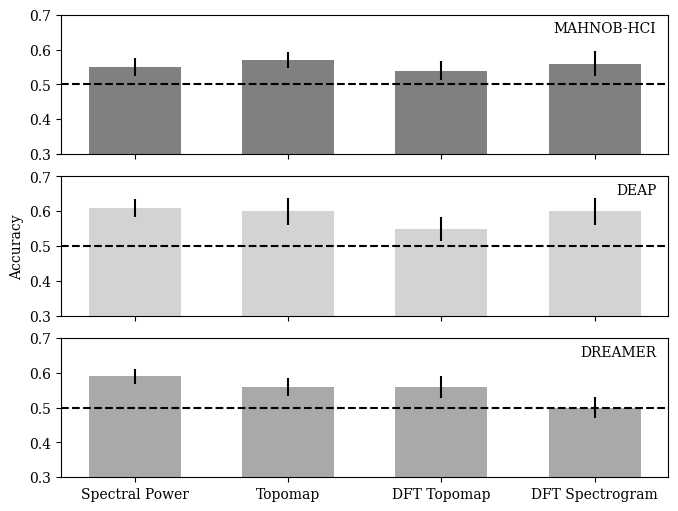

In [26]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.family': 'serif'})
features = ("Spectral Power", "Topomap", "DFT Topomap", "DFT Spectrogram")
dataset_means = {
    'MAHNOB-HCI': data[0,:,0],
    'DEAP': data[1,:,0],
    'DREAMER': data[2,:,0],
}
dataset_stderr = {
    'MAHNOB-HCI': data[0,:,1],
    'DEAP': data[1,:,1],
    'DREAMER': data[2,:,1],
}
x = np.arange(0,len(features)/4, 0.25)  # the label locations
print(x)
width = 0.15  # the width of the bars
multiplier = 0

fig, axs = plt.subplots(nrows=3, ncols=1, layout='constrained', sharex=True)

color = {
    'MAHNOB-HCI': 'grey',
    'DEAP': 'lightgrey',
    'DREAMER': 'darkgrey'
}
for i, (ds, mean_acc) in enumerate(dataset_means.items()):
    # offset = width * multiplier
    rects = axs[i].bar(x, np.round(mean_acc,2), width, yerr=dataset_stderr[ds], label=ds, color=color[ds]) # bar plot
    # axs[i].bar_label(rects, padding=3) # number on top of bar
    axs[i].axhline(y = 0.5, color = 'k', linestyle = '--') # horizontal line through plot
    axs[i].set_ylim(0.3, 0.7) # y scale
    # axs[i].legend(loc='upper right', ncols=3)
    axs[i].text(0.98, 0.9, ds, horizontalalignment='right',  # text instead of legend
                             verticalalignment='center',
                             transform = axs[i].transAxes)
    # multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_ylabel('Accuracy')
axs[-1].set_xticks(x, features) # x tick labels


my_dpi=60
fig.set_figwidth(400/my_dpi)
fig.set_figheight(300/my_dpi)
plt.show()

fig.savefig('standard_vs_DFT.svg', dpi=my_dpi)
fig.savefig('standard_vs_DFT.png', dpi=my_dpi)

# Random Projection

In [40]:
path = '/net2/sandbox/deep-eeg/nb-results'

results = ['result_avgfreqpwr_rp_pc', 'result_rp_pc', 'result_specto_rp_pc', ]
#               RP(avgfreqpwr)           RP(topo)       RP(VGG(spectrogram))          
datasets = ['mahnob', 'deap', 'dreamer']
data = np.zeros((len(datasets), len(results), 2))
for d, ds in enumerate(datasets):
    print(ds)
    
    for f, feat in enumerate(results):
        data_acc = []
        if ds == 'mahnob':
            result_file = os.path.join(path, f'{feat}.pkl')
        else:
            result_file = os.path.join(path, f'{ds}_{feat}.pkl')
        with open(result_file, 'rb') as fin:
            result = pickle.load(fin)
            data_acc.append((result['train_acc'], result['acc']))
        if ds == 'mahnob':
            y_mean, yerr_mean  = gen_y(np.nanmean, data_acc)
            # print(y_mean)
            y_median, yerr_median  = gen_y(np.nanmedian, data_acc)   
        else:
            y_mean, yerr_mean  = gen_y_deap(np.nanmean, data_acc)
            # print(y_mean)
        data[d,f,0] = y_mean
        data[d,f,1] = yerr_mean
print(data)

mahnob
deap
dreamer
[[[0.52324017 0.02460034]
  [0.51162008 0.01840351]
  [0.57746032 0.03714938]]

 [[0.60904498 0.02644784]
  [0.59180911 0.03657537]
  [0.59172127 0.04036645]]

 [[0.58937198 0.02180321]
  [0.56521739 0.02593716]
  [0.49516908 0.02687854]]]


/tmp/ipykernel_1071/1692967976.py:14: RuntimeWarning: Mean of empty slice
  y = np.nanmean(y, axis=-1) # 4 -> Subjects


[0.   0.25 0.5 ]


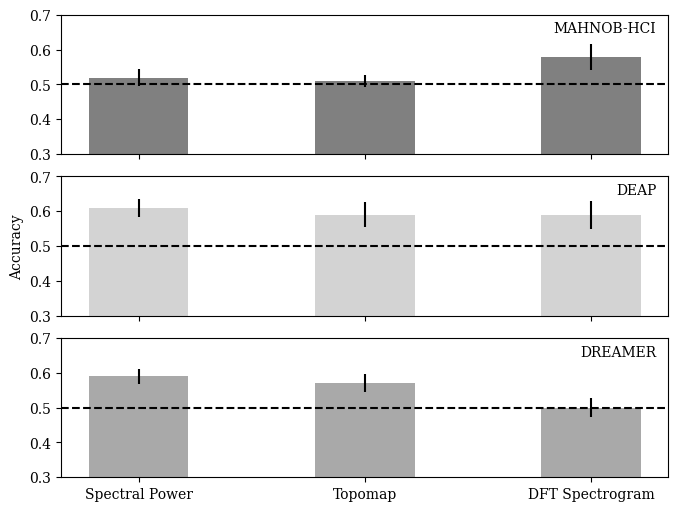

In [41]:
import matplotlib.pyplot as plt
import numpy as np

features = ("Spectral Power", "Topomap", "DFT Spectrogram" )
dataset_means = {
    'MAHNOB-HCI': data[0,:,0],
    'DEAP': data[1,:,0],
    'DREAMER': data[2,:,0],
}
dataset_stderr = {
    'MAHNOB-HCI': data[0,:,1],
    'DEAP': data[1,:,1],
    'DREAMER': data[2,:,1],
}
x = np.arange(0,len(features)/4, 0.25)  # the label locations
print(x)
width = 0.11  # the width of the bars
multiplier = 0

fig, axs = plt.subplots(nrows=3, ncols=1, layout='constrained', sharex=True)

color = {
    'MAHNOB-HCI': 'grey',
    'DEAP': 'lightgrey',
    'DREAMER': 'darkgrey'
}
for i, (ds, mean_acc) in enumerate(dataset_means.items()):
    # offset = width * multiplier
    rects = axs[i].bar(x, np.round(mean_acc,2), width, yerr=dataset_stderr[ds], label=ds, color=color[ds]) # bar plot
    # axs[i].bar_label(rects, padding=3) # number on top of bar
    axs[i].axhline(y = 0.5, color = 'k', linestyle = '--') # horizontal line through plot
    axs[i].set_ylim(0.3, 0.7) # y scale
    # axs[i].legend(loc='upper right', ncols=3)
    axs[i].text(0.98, 0.9, ds, horizontalalignment='right',  # text instead of legend
                             verticalalignment='center',
                             transform = axs[i].transAxes)
    # multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_ylabel('Accuracy')
axs[-1].set_xticks(x, features) # x tick labels


my_dpi=60
fig.set_figwidth(400/my_dpi)
fig.set_figheight(300/my_dpi)
plt.show()

fig.savefig('RP.svg', dpi=my_dpi)
fig.savefig('RP.png', dpi=my_dpi)

# Model comparison

In [70]:
path = '/net2/sandbox/deep-eeg/nb-results/unbalanced'

results = ['result_vgg16', 'result_alexnet', 'result_incepv3', 'result_vgg16_straw_randinit', 'result_alexnet_straw_randinit', 'result_incepv3_straw_randinit']
#               RP(avgfreqpwr)           RP(topo)       RP(VGG(spectrogram))          
datasets = ['mahnob', 'deap', 'dreamer']
data = np.zeros((len(datasets), len(results), 2))
for d, ds in enumerate(datasets):
    print(ds)
    
    for f, feat in enumerate(results):
        data_acc = []
        if ds == 'mahnob':
            result_file = os.path.join(path, f'{feat}.pkl')
        else:
            result_file = os.path.join(path, f'{ds}_{feat}.pkl')
        with open(result_file, 'rb') as fin:
            result = pickle.load(fin)
            data_acc.append((result['train_acc'], result['acc']))
        if ds == 'mahnob':
            y_mean, yerr_mean  = gen_y(np.nanmean, data_acc)
            # print(y_mean)
            y_median, yerr_median  = gen_y(np.nanmedian, data_acc)   
        else:
            y_mean, yerr_mean  = gen_y_deap(np.nanmean, data_acc)
            # print(y_mean)
        data[d,f,0] = y_mean
        data[d,f,1] = yerr_mean
print(data)

mahnob
deap
dreamer
[[[0.53716356 0.02743036]
  [0.48949275 0.02784291]
  [0.56252588 0.02292836]
  [0.56438923 0.02848775]
  [0.52986542 0.0375062 ]
  [0.57608696 0.02642084]]

 [[0.54888192 0.03426291]
  [0.61552826 0.0309022 ]
  [0.55822283 0.03303887]
  [0.6160473  0.03780655]
  [0.62082925 0.03372559]
  [0.56741156 0.03029045]]

 [[0.56280193 0.03155006]
  [0.53623188 0.0300933 ]
  [0.55555556 0.02938533]
  [0.5821256  0.02598602]
  [0.57004831 0.03171846]
  [0.59178744 0.03287309]]]


/tmp/ipykernel_1071/1692967976.py:14: RuntimeWarning: Mean of empty slice
  y = np.nanmean(y, axis=-1) # 4 -> Subjects


[0.54888192 0.61552826 0.55822283]
[0.6160473  0.62082925 0.56741156]
[0.  0.5 1. ]


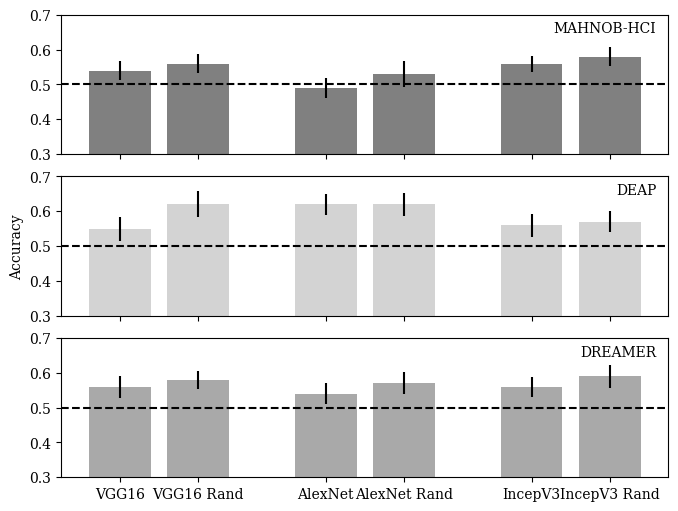

In [71]:
import matplotlib.pyplot as plt
import numpy as np

features = ["VGG16", "AlexNet", "IncepV3"]
features_rand = ["VGG16 Rand", "AlexNet Rand", "IncepV3 Rand"] 
dataset_means = {
    'MAHNOB-HCI': data[0,0:3,0],
    'DEAP': data[1,0:3,0],
    'DREAMER': data[2,0:3,0],
}
print(dataset_means['DEAP'])
dataset_stderr = {
    'MAHNOB-HCI': data[0,0:3,1],
    'DEAP': data[1,0:3,1],
    'DREAMER': data[2,0:3,1],
}
dataset_means_rand = {
    'MAHNOB-HCI': data[0,3:,0],
    'DEAP': data[1,3:,0],
    'DREAMER': data[2,3:,0],
}
print(dataset_means_rand['DEAP'])
dataset_stderr_rand = {
    'MAHNOB-HCI': data[0,3:,1],
    'DEAP': data[1,3:,1],
    'DREAMER': data[2,3:,1],
}
x = np.arange(0,3/2, 0.5)  # the label locations
print(x)
width = 0.15  # the width of the bars
multiplier = 0

fig, axs = plt.subplots(nrows=3, ncols=1, layout='constrained', sharex=True)

color = {
    'MAHNOB-HCI': 'grey',
    'DEAP': 'lightgrey',
    'DREAMER': 'darkgrey'
}
for i, (ds, mean_acc) in enumerate(dataset_means.items()):
    # offset = width * multiplier
    rects = axs[i].bar(x, np.round(mean_acc,2), width, yerr=dataset_stderr[ds], label=ds, color=color[ds]) # bar plot
    rects = axs[i].bar(x + 0.19, np.round(dataset_means_rand[ds],2), width, yerr=dataset_stderr_rand[ds], label=ds, color=color[ds]) # bar plot
    # axs[i].bar_label(rects, padding=3) # number on top of bar
    axs[i].axhline(y = 0.5, color = 'k', linestyle = '--') # horizontal line through plot
    axs[i].set_ylim(0.3, 0.7) # y scale
    # axs[i].legend(loc='upper right', ncols=3)
    axs[i].text(0.98, 0.9, ds, horizontalalignment='right',  # text instead of legend
                             verticalalignment='center',
                             transform = axs[i].transAxes)
    # multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_ylabel('Accuracy')
# axs[-1].set_xticks(x, features)
plt.xticks([0., 0.19, 0.5, 0.69, 1, 1.19], ["VGG16", "VGG16 Rand", "AlexNet", "AlexNet Rand", "IncepV3", "IncepV3 Rand"])

my_dpi=60
fig.set_figwidth(400/my_dpi)
fig.set_figheight(300/my_dpi)
plt.show()

fig.savefig('randinit.svg', dpi=my_dpi)
fig.savefig('randinit.png', dpi=my_dpi)

# Unsupervised finetuning

In [14]:
path = '/net2/sandbox/deep-eeg/nb-results/unbalanced'

results = ['result_vgg16', 'result_specto_vgg16', 'result_finetune_ae_topo', 'result_finetune_ae_specto']
#               RP(avgfreqpwr)           RP(topo)       RP(VGG(spectrogram))          
datasets = ['mahnob', 'deap', 'dreamer']
data = np.zeros((len(datasets), len(results), 2))
for d, ds in enumerate(datasets):
    print(ds)
    
    for f, feat in enumerate(results):
        if ds == 'dreamer' and feat in ['result_finetune_ae_specto']:
            continue
        if ds == 'deap' and feat == 'result_finetune_ae_specto':
            continue
        data_acc = []
        if ds == 'mahnob':
            result_file = os.path.join(path, f'{feat}.pkl')
        else:
            result_file = os.path.join(path, f'{ds}_{feat}.pkl')
        with open(result_file, 'rb') as fin:
            result = pickle.load(fin)
            data_acc.append((result['train_acc'], result['acc']))
        if ds == 'mahnob':
            y_mean, yerr_mean  = gen_y(np.nanmean, data_acc)
            # print(y_mean)
            y_median, yerr_median  = gen_y(np.nanmedian, data_acc)   
        else:
            y_mean, yerr_mean  = gen_y_deap(np.nanmean, data_acc)
            # print(y_mean)
        data[d,f,0] = y_mean
        data[d,f,1] = yerr_mean
print(data)

mahnob
deap
dreamer
[[[0.53716356 0.02743036]
  [0.55690476 0.03632428]
  [0.58056452 0.03393206]
  [0.51391719 0.01120628]]

 [[0.54888192 0.03426291]
  [0.59543132 0.0381211 ]
  [0.61735388 0.04692095]
  [0.         0.        ]]

 [[0.56280193 0.03155006]
  [0.50241546 0.02948013]
  [0.5531401  0.03424134]
  [0.         0.        ]]]


/tmp/ipykernel_11189/1692967976.py:14: RuntimeWarning: Mean of empty slice
  y = np.nanmean(y, axis=-1) # 4 -> Subjects


[0.54888192 0.59543132]
[0.61735388 0.        ]
[0.  0.5]
MAHNOB-HCI
DEAP
DREAMER


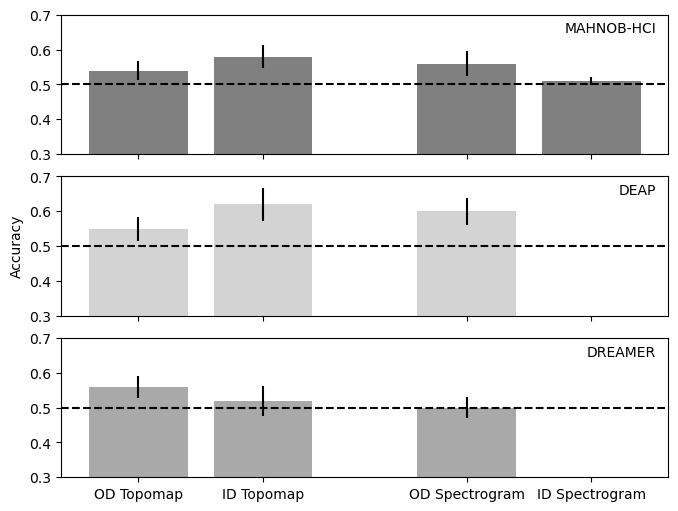

In [7]:
import matplotlib.pyplot as plt
import numpy as np

features = ["OD Topo", "OD Specto"]
features_rand = ["ID Topo", "ID Specto"] 
dataset_means = {
    'MAHNOB-HCI': data[0,0:2,0],
    'DEAP': data[1,0:2,0],
    'DREAMER': data[2,0:2,0],
}
print(dataset_means['DEAP'])
dataset_stderr = {
    'MAHNOB-HCI': data[0,0:2,1],
    'DEAP': data[1,0:2,1],
    'DREAMER': data[2,0:2,1],
}
dataset_means_rand = {
    'MAHNOB-HCI': data[0,2:,0],
    'DEAP': data[1,2:,0],
    'DREAMER': data[2,2:,0],
}
print(dataset_means_rand['DEAP'])
dataset_stderr_rand = {
    'MAHNOB-HCI': data[0,2:,1],
    'DEAP': data[1,2:,1],
    'DREAMER': data[2,2:,1],
}
x = np.arange(0, 1, 0.5)  # the label locations
print(x)
width = 0.15  # the width of the bars
multiplier = 0

fig, axs = plt.subplots(nrows=3, ncols=1, layout='constrained', sharex=True)

color = {
    'MAHNOB-HCI': 'grey',
    'DEAP': 'lightgrey',
    'DREAMER': 'darkgrey'
}
for i, (ds, mean_acc) in enumerate(dataset_means.items()):
    print(ds)
    # offset = width * multiplier
    rects = axs[i].bar(x, np.round(mean_acc,2), width, yerr=dataset_stderr[ds], label=ds, color=color[ds]) # bar plot
    rects = axs[i].bar(x + 0.19, np.round(dataset_means_rand[ds],2), width, yerr=dataset_stderr_rand[ds], label=ds, color=color[ds]) # bar plot
    # axs[i].bar_label(rects, padding=3) # number on top of bar
    axs[i].axhline(y = 0.5, color = 'k', linestyle = '--') # horizontal line through plot
    axs[i].set_ylim(0.3, 0.7) # y scale
    # axs[i].legend(loc='upper right', ncols=3)
    axs[i].text(0.98, 0.9, ds, horizontalalignment='right',  # text instead of legend
                             verticalalignment='center',
                             transform = axs[i].transAxes)
    # multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_ylabel('Accuracy')
# axs[-1].set_xticks(x, features)
plt.xticks([0., 0.19, 0.5, 0.69], ["OD Topomap", "ID Topomap", "OD Spectrogram", "ID Spectrogram"])

my_dpi=60
fig.set_figwidth(400/my_dpi)
fig.set_figheight(300/my_dpi)
plt.show()

fig.savefig('finetune.svg', dpi=my_dpi)
fig.savefig('finetune.png', dpi=my_dpi)

[0.61735388 0.        ]
[0.  0.5 1. ]


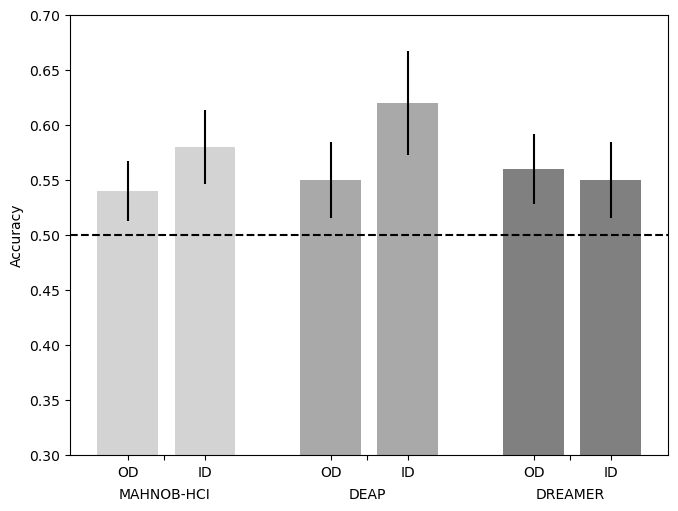

In [18]:
import matplotlib.pyplot as plt
import numpy as np
# topomap only
features = ["OD Topo", "OD Topo", "OD Topo"]
features_rand = ["ID Topo", "ID Topo", "ID Topo"] 

od_means = data[:, 0, 0]
# {
#     'MAHNOB-HCI': data[0,0:2,0],
#     'DEAP': data[1,0:2,0],
#     'DREAMER': data[2,0:2,0],
# }
# print(dataset_means['DEAP'])
# dataset_stderr = {
#     'MAHNOB-HCI': data[0,0:2,1],
#     'DEAP': data[1,0:2,1],
#     'DREAMER': data[2,0:2,1],
# }
od_stderr = data[:, 0, 1]

dataset_means_rand = {
    'MAHNOB-HCI': data[0,2:,0],
    'DEAP': data[1,2:,0],
    'DREAMER': data[2,2:,0],
}
print(dataset_means_rand['DEAP'])
id_means = data[:, 2, 0]
# dataset_stderr_rand = {
#     'MAHNOB-HCI': data[0,2:,1],
#     'DEAP': data[1,2:,1],
#     'DREAMER': data[2,2:,1],
# }
id_stderr = data[:,2, 1]
x = np.arange(0, 1.5, 0.5)  # the label locations
print(x)
width = 0.15  # the width of the bars
multiplier = 0

fig, axs = plt.subplots(nrows=1, ncols=1, layout='constrained', sharex=True)

color = {
    'MAHNOB-HCI': 'grey',
    'DEAP': 'lightgrey',
    'DREAMER': 'darkgrey'
}

rects = axs.bar(x, np.round(od_means,2), width, yerr=od_stderr, label=ds, color=['lightgrey', 'darkgrey', 'grey']) # bar plot
rects = axs.bar(x + 0.19, np.round(id_means,2), width, yerr=id_stderr, label=ds, color=['lightgrey', 'darkgrey', 'grey']) # bar plot
axs.axhline(y = 0.5, color = 'k', linestyle = '--') # horizontal line through plot
axs.set_ylim(0.3, 0.7) # y scale

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_ylabel('Accuracy')
# axs[-1].set_xticks(x, features)
plt.xticks([0., 0.09, 0.19, 0.5, 0.59, 0.69, 1, 1.09, 1.19], ["OD", "MAHNOB-HCI", "ID", "OD", "DEAP", "ID", "OD", "DREAMER", "ID"])
# plt.xticks([0., 0.19, 0.5], ["Mahnob", "DEAP", "DREAMER"], minor=False)

# vertical alignment of xtick labels
va = [ 0, -.05, 0, 0, -.05, 0, 0, -.05,0 ]
for t, y in zip( axs.get_xticklabels( ), va ): # set y for xticks label
    t.set_y( y )
    
my_dpi=60
fig.set_figwidth(400/my_dpi)
fig.set_figheight(300/my_dpi)
plt.show()

fig.savefig('finetune.svg', dpi=my_dpi)
fig.savefig('finetune.png', dpi=my_dpi)